Load model and tokenizer

In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps" if not torch.cuda.is_available() else "cuda"
out_dir = "checkpoint/base"
# out_dir = "checkpoint/run3"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)
model = model.to(device)
model.eval()

# Load tokenizer 
# (1). base tokenizer
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

# (2). input tokenizer
# if 'tokenizer_path' in checkpoint: 
    # tok = ETokenizer.load(checkpoint["tokenizer_path"])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_90417/1889586053.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


In [23]:
# Base on vocabulary size, calculate flops required to train the previous 'compute_matching' checkpoints 

max_iter = 5000
batch_size = 64
gradient_accumulation_steps = 1

# Comput-matching Flops calculation
vocabulary_sizes = [92, 4359, 7941, 11382, 14819, 18276]
im_flops = []
iv_flops = []
iv_flop = 0
accumulated_iter = 0
for idx in range(len(vocabulary_sizes)):
    gpt_config = GPTConfig(vocab_size=vocabulary_sizes[idx], block_size=512, n_layer=6, n_head=6, n_embd=384, dropout=0.2) # tiny-gpt config
    gpt = GPT(gpt_config)
    flops_per_fwdbwd = gpt.estimate_flops()
    fwdbwd_per_iter = batch_size * gradient_accumulation_steps 
    flop_per_iter = flops_per_fwdbwd * fwdbwd_per_iter 
    accumulated_iter += max_iter
    
    # Iteration matching runs train from-scratch with accumulated iterations 
    im_flop = flop_per_iter * accumulated_iter
    im_flops.append(im_flop)
    
    # Incremental vocabulary runs accumulate flops with fixed iterations per step
    iv_flop += flop_per_iter * max_iter
    iv_flops.append(iv_flop)

number of parameters: 10.68M
number of parameters: 12.32M
number of parameters: 13.70M
number of parameters: 15.02M
number of parameters: 16.34M
number of parameters: 17.67M


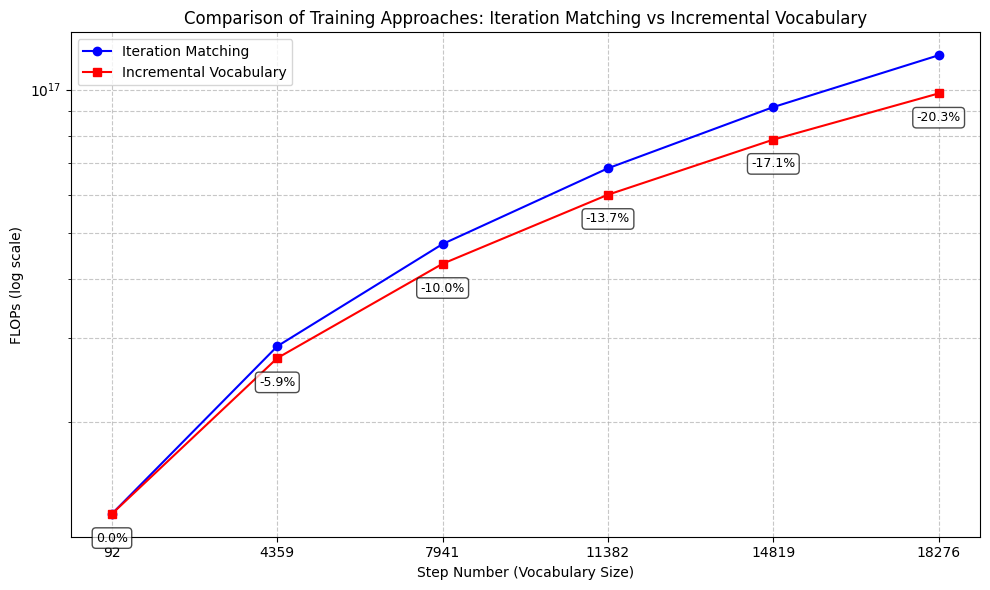

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Create step numbers for x-axis (0-5 corresponding to the 6 vocabulary sizes)
steps = list(range(len(im_flops)))

cost_reduction = [(i2-i1) / i2 for i1, i2 in zip(im_flops, iv_flops)]

# Create the plot
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, im_flops, 'o-', color='blue', label='Iteration Matching')
plt.plot(steps, iv_flops, 's-', color='red', label='Incremental Vocabulary')

# Add cost reduction ratio annotations
for i, (x, y1, y2, ratio) in enumerate(zip(steps, im_flops, iv_flops, cost_reduction)):
    # Format the ratio as percentage
    percentage = f"{ratio*100:.1f}%"
    # Position the text slightly above the lower point (im_flops)
    plt.annotate(percentage, 
                 xy=(x, y2), 
                 xytext=(0, -20),  # Offset text 10 points above
                 textcoords='offset points',
                 ha='center',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

# Set y-axis to log scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Step Number')
plt.ylabel('FLOPs (log scale)')
plt.title('Comparison of Training Approaches: Iteration Matching vs Incremental Vocabulary')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend()

# Add vocabulary sizes as x-tick labels
vocabulary_sizes = [92, 4359, 7941, 11382, 14819, 18276]
plt.xticks(steps, vocabulary_sizes)
plt.xlabel('Step Number (Vocabulary Size)')

# Show the plot
plt.tight_layout()
plt.show()

Generate from model

In [3]:
model.eval() 

# model = torch.compile(model)
query = "Hello, how are you?"
query_tokens = tok.encode(query)
query_tokens = torch.tensor(query_tokens, dtype=torch.long, device=device).unsqueeze(0)

# generate from model 
output = model.generate(query_tokens, max_new_tokens=256, stop_ids=[tok.eos_token])

# decode the generated tokens 
decoded_output = tok.decode(output[0].tolist())


In [16]:
decoded_output

'Hello, how are you? Ultra--andjacent you?  Other you! /ref . Other influenzees include*Pine postdology*Pine piinter*Pine postdology*Percion music by considering Swiss Marshall*South African ruler*Summer antitrums say that Gell, marginalism could a higher south of the west to'

Tokenizer Encoding speed optimisation 

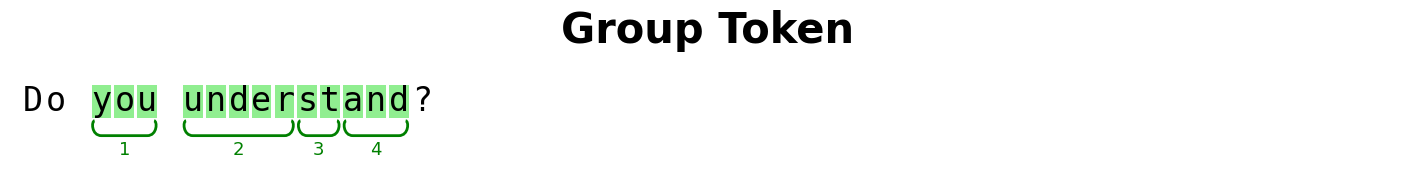

In [2]:
from magicab import Magicab

magicab = Magicab(model, 
                  tokenizer=tok, # input tokenizer
                  checkpoint_dir="checkpoint/base", spike_perplexity_threshold=5.0, group_perplexity_threshold=10.5)

magicab.group_quantile_threshold = 1.0

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]
texts = ["Do you understand?"]

# (a). Batch Visualizer
char_perplexity = magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [2]:
# Supervised-Fine-Tuning on GPT model 

# An example of SFT data 

# Apply Chat Template with ETokenizer
conv_data = [{"user": "hi"}]
tok.apply_chat_template(conv_data) # backward-crop for inference-time chat template application 

conv_data = [{"user": "hi"}, {"assistant": "hello"}]
tok.prepare_sft_data(conv_data) # sft data processing require context length handling and randomization

# Build SFT trainer (basically apply the loss_mask)

'<USER> hi<|endoftext|><ASSISTANT> hello<|endoftext|>'

In [34]:
from data.alpaca.util import prepare_alpaca_data, get_batch

# Alpaca data preparation with tokenizer
prepare_alpaca_data(tok, block_size=512)

# Batch data loader with Alpaca 
input_ids, target_ids, loss_mask = get_batch(10, 'train', 'mps')

Sample conversation format:
[{'user': 'Give three tips for staying healthy.'}, {'assistant': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}]

Formatted text length: 283
Loss mask length: 242

Successfully processed 30965 samples
- Total Training samples: 27868
- Total Validation samples: 3097


In [ ]:
# Check validity of pre-train data tokenization
import glob
import pickle

data_dir = "data/enwiki"
pkl_path = glob.glob(data_dir + "/gpt_medium/*.pkl")[0]  # Get the first .pkl file

# Open the file properly before loading
with open(pkl_path, "rb") as f:
    data = pickle.load(f)

# Now `data` contains the unpickled object
print("Successfully loaded pickle file:", pkl_path)

#### Scaling up pre-training data corpus size 

In [2]:
# test download smollm-corpus 
from datasets import load_from_disk
from data.composio.download_pt_data import download_fineweb_edu

download_fineweb_edu("data/composio", "cache", 1, 200)

dataset = load_from_disk("data/composio/fineweb-edu")
train_size = 100 
tokenizer = tok 
        
def process_fineweb_edu(example, tokenizer, max_length=2048):
    # When batched=True, example['text'] is a list of texts
    texts = example['text']
    all_ids = []
    
    # Process each text individually
    for text in texts:
        if isinstance(text, str):  # Ensure text is a string
            ids = tokenizer.encode_with_chunking(text)
            all_ids.append(ids)
        else:
            # Handle unexpected data type
            all_ids.append([])
            
    return {"ids": all_ids}

train_dataset = dataset.select(range(train_size)).map(
    process_fineweb_edu, 
    fn_kwargs={'tokenizer': tokenizer, 'max_length': 512},
    num_proc=1,
    remove_columns=["text"],
    batched=True,
    desc="Processing fineweb-edu train"
)